In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import bertopic

## Mean-Variance Analysis

### Monthly Returns

In [2]:
returns_data = pd.read_csv('returns_2018_top5_SIC.csv', 
                      parse_dates = ['DATE'], 
                      usecols = ["trt1m", "CIK", "name", "DATE"])
#returns_data.info()

In [3]:
# TAKE OUT THE DATA before 2019 and reset index
end_date = pd.to_datetime('2019-01-01')
returns = returns_data.loc[(returns_data['DATE'] < end_date)]
# drop the missing value
returns = returns.dropna()

In [4]:
#returns

In [5]:
date = pd.DataFrame(returns.DATE.unique())

In [6]:
group_returns = returns.groupby(['CIK', 'DATE'])
#group_returns.first()

In [7]:
# calculate the percentage return
group_returns_pct = group_returns.agg({"trt1m": (lambda x:  x/100)})
#group_returns_pct

In [8]:
# unstack the dataframe and get the product of each month's return to generate annual return
r_selected = group_returns_pct.unstack()
# drop the first index
r_selected.columns = r_selected.columns.droplevel(0)

In [10]:
# there are some rows containing more than one float number (array of multiple returns)
for i in range(len(r_selected)):
    if type(r_selected.iloc[i,1]) == np.ndarray:
        r_selected = r_selected.drop(index = r_selected.index[i])
# convert object to float
r_selected = r_selected.astype(float)
# drop missing values rows
r_selected = r_selected.dropna()

In [11]:
#r_selected

In [13]:
# get the mean of all 
mu = r_selected.mean(axis = 1)
#mu

In [14]:
# compute the covariance matrix 
cov = r_selected.T.cov()
#cov

### Cosine Similarity Distances

In [15]:
df = pd.read_csv('preprocessed.csv',
                 usecols = ['reportingDate', 'name', 'CIK',
                           'coDescription_stopwords', 'SIC', 'SIC_desc'])
df = df.set_index(df.CIK)
#df

#### Words Count

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

Vectorizer = CountVectorizer(ngram_range = (2,4), 
                             max_features = 1000)

count_data = Vectorizer.fit_transform(df['coDescription_stopwords'])
wordsCount = pd.DataFrame(count_data.toarray(),columns=Vectorizer.get_feature_names())
wordsCount = wordsCount.set_index(df['CIK'])
#wordsCount

/Users/lulu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [109]:
# Compute Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = pd.DataFrame(cosine_similarity(wordsCount, wordsCount))
cosine_sim = cosine_sim.set_index(df['CIK'])
cosine_sim.columns = df['CIK']
#cosine_sim

### Perform Mean-Variance Analysis

In [18]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

In [19]:
# get the names of the companies in the pharmaceutical preparations industry
Pharm = df[df.SIC == 2834]
Pharm_list = Pharm.index

In [20]:
# get the companies name that match return data and business description data
SET = (set(Pharm_list) & set(r_selected.index))
#type(SET)

In [21]:
LIST = [*SET, ]
len(LIST)

124

#### Mean and Covariance for Returns in the Pharmaceutical Preparations Industry

In [22]:
mu_Pharm = mu[LIST]
#mu_Pharm

In [23]:
tmp = cov[LIST].T
cov_Pharm = tmp[LIST]

In [108]:
#cov_Pharm

#### Cosine Similarity Distances in the Pharmaceutical Preparations Industry

In [25]:
tmp = cosine_sim[LIST].drop_duplicates().T
Pharm_cos_sim = tmp[LIST].drop_duplicates()
#Pharm_cos_sim

#### Covariance for Cosine Similarity

In [94]:
cos_sim_sd = pd.DataFrame(np.sqrt(np.diag(np.diagonal(cov_Pharm))))
cos_sim_sd = cos_sim_sd.set_index(cov_Pharm.index)
cos_sim_sd.columns = cov_Pharm.index
#cos_sim_sd

In [107]:
cos_sim_cov = pd.DataFrame((np.dot(np.dot(cos_sim_sd, Pharm_cos_sim),cos_sim_sd)))
#cos_sim_cov

### Portfolio Weights on Different Extremes

#### Comparing return mean and covariance

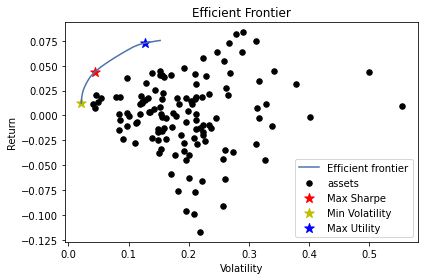

In [98]:
ef1 = EfficientFrontier(mu_Pharm, cov_Pharm, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, cov_Pharm, weight_bounds=(0, 0.2))
# max sharpe ratio
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

ef3 = EfficientFrontier(mu_Pharm, cov_Pharm, weight_bounds=(0, 0.2))
# min volatility
ef3.min_volatility()
ret_tangent, std_tangent, _ = ef3.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="y", label="Min Volatility")

ef4 = EfficientFrontier(mu_Pharm, cov_Pharm, weight_bounds=(0, 0.2))
#max utility
ef4.max_quadratic_utility()
ret_tangent, std_tangent, _ = ef4.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="b", label="Max Utility")

# Plot random portfolios
#ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.show()

##### max sharpe ratio

In [32]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 4.4%
Annual volatility: 4.4%
Sharpe Ratio: 0.54


In [33]:
company_list = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        company_list.append(int(company))
        print(company, weight)

1070081 0.08381
1641489 0.02599
874015 0.09513
1177648 0.02332
1600132 0.02205
1326732 0.02668
1103021 0.15005
1582313 0.05674
1588972 0.02686
1360214 0.12169
1526119 0.00106
1133416 0.02079
1426800 0.2
899460 0.03184
868278 0.11385
1369568 0.00014


##### min volatility

In [34]:
ef3.portfolio_performance(verbose=True);

Expected annual return: 1.2%
Annual volatility: 2.1%
Sharpe Ratio: -0.35


In [35]:
for company, weight in ef3.clean_weights().items():
    if weight != 0:
        print(company, weight)

1641489 0.02372
1092662 0.02843
1103021 0.0368
200406 0.17878
1582313 0.0135
1588972 0.0201
1176309 0.04982
1501989 0.0052
1509190 0.03678
1555280 0.01195
1360214 0.04181
1476963 0.00297
1426800 0.05775
899460 0.02048
310158 0.2
868278 0.0512
14272 0.12824
1264587 0.04273
1535955 0.00683
1478121 0.03777
1301501 0.00515


##### maximize utility

In [36]:
ef4.portfolio_performance(verbose=True);

Expected annual return: 7.3%
Annual volatility: 12.8%
Sharpe Ratio: 0.41


In [37]:
for company, weight in ef.clean_weights().items():
    if weight != 0:
        print(company, weight)

1070081 0.2
1641489 0.03969
1042074 0.07716
1576263 0.08242
873303 0.2
1133416 0.11323
1426800 0.2
1369568 0.0875


#### Comparing return mean and covariance from cosine similarity

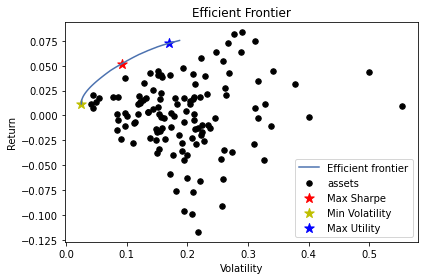

In [99]:
ef1 = EfficientFrontier(mu_Pharm, cos_sim_cov, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, cos_sim_cov, weight_bounds=(0, 0.2))
# max sharpe ratio
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

ef3 = EfficientFrontier(mu_Pharm, cos_sim_cov, weight_bounds=(0, 0.2))
# min volatility
ef3.min_volatility()
ret_tangent, std_tangent, _ = ef3.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="y", label="Min Volatility")

ef4 = EfficientFrontier(mu_Pharm, cos_sim_cov, weight_bounds=(0, 0.2))
#max utility
ef4.max_quadratic_utility()
ret_tangent, std_tangent, _ = ef4.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="b", label="Max Utility")

# Plot random portfolios
#ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.show()

##### max sharpe ratio

In [100]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 5.2%
Annual volatility: 9.2%
Sharpe Ratio: 0.35


In [101]:
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        print(company, weight)

1070081 0.11478
1326732 0.2
1042074 0.09287
1019695 0.0312
1597264 0.08623
1555280 0.09839
873303 0.06223
1426800 0.1143
868278 0.2


##### min volatility

In [102]:
ef3.portfolio_performance(verbose=True);

Expected annual return: 1.2%
Annual volatility: 2.5%
Sharpe Ratio: -0.33


In [104]:
for company, weight in ef3.clean_weights().items():
    if weight != 0:
        print(company, weight)

1396814 0.01634
59478 0.03622
875622 0.07181
1326732 0.02068
78003 0.2
1585364 0.01781
200406 0.19015
1019695 0.00325
1555280 0.2
818033 0.00572
310158 0.13299
1048477 0.04223
14272 0.04703
1175505 0.01577


##### max utility

In [105]:
ef4.portfolio_performance(verbose=True);

Expected annual return: 7.3%
Annual volatility: 17.0%
Sharpe Ratio: 0.31


In [106]:
for company, weight in ef4.clean_weights().items():
    if weight != 0:
        print(company, weight)

1070081 0.2
1326732 0.08098
1042074 0.2
1576263 0.11902
873303 0.2
1426800 0.2


### Try the differences between 2017 and 2018

In [45]:
data = pd.read_csv("timeseries_data.csv")
filtered = data[data["reports"] > 2].sort_values(["CIK","filingDate"])
#filtered

In [46]:
# Referenced from Richard's Week 8 Work
from sklearn.feature_extraction.text import CountVectorizer
company = filtered.sort_values(["CIK","filingDate"]) 
# print(company)
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=1000)
X = vectorizer.fit_transform(company.loc[:, "coDescription_stopwords"]).toarray().astype(int)
diff = pd.DataFrame(X[1:,:] - X[:-1,:],
                    columns = vectorizer.get_feature_names_out()) 

#diff

In [47]:
total_diff = diff[(diff.reset_index().index+1) % 3 != 0]
total_diff
y2_to_y3 = total_diff.iloc[1::2, :]
y2_to_y3

,ability,able,access,accessory,accordance,according,account,accounted,accounting,accrued,...,work,working,world,worldwide,would,written,year,year ended,year ended september,york
1,0,0,0,0,0,0,0,0,0,0,...,0,-1,0,0,0,0,8,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,-1,0,0,-2,0,0,0
10,0,0,2,-1,0,0,-1,0,-1,0,...,0,0,0,0,0,0,1,0,0,0
13,0,0,0,0,-2,0,0,0,0,0,...,0,0,0,0,-1,0,-3,-2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-4,0,0,0
1681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1684,-10,-8,1,0,-6,4,-34,3,-2,-4,...,2,-11,-2,6,-46,-3,0,2,0,0
1687,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
y2_to_y3 = y2_to_y3.set_index(filtered["CIK"].unique())

In [49]:
SET = (set(filtered["CIK"].unique()) & set(mu.index))
LIST = [*SET, ]
len(LIST)

22

In [50]:
tmp = y2_to_y3.T[LIST]
y2_to_y3_select = tmp.T

In [51]:
y2_to_y3_select

,ability,able,access,accessory,accordance,according,account,accounted,accounting,accrued,...,work,working,world,worldwide,would,written,year,year ended,year ended september,york
876167,0,0,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-1,-1,0,0
1002517,0,-1,-1,0,0,0,0,0,0,0,...,-1,0,1,0,0,0,5,0,0,0
798359,0,0,-2,0,0,0,0,-2,-4,-1,...,0,-1,0,0,0,-1,1,0,0,-1
1169561,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1378590,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-2,0,0,1
67625,0,0,0,0,0,0,0,0,0,-1,...,0,0,1,0,0,0,8,-1,-2,-1
1177648,-1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,2,0,0,1,1,0
10048,0,1,-1,0,0,0,1,0,-1,0,...,0,1,-1,0,0,0,-1,-1,-1,0
792130,-1,0,0,0,2,-1,0,0,0,0,...,0,0,0,-1,1,0,-1,0,0,0
1353283,0,0,-2,0,0,0,1,0,0,0,...,0,0,0,-1,0,0,0,0,0,0


In [52]:
cov_select = (y2_to_y3_select.T.cov()/100)

In [53]:
mu_select = mu[LIST]
#mu_select

In [54]:
tmp = cov[LIST].T
S_select = tmp[LIST]
#S_select

#### Comparing return mean and covariance

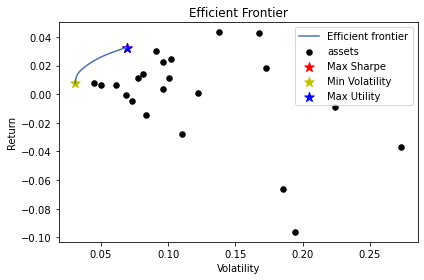

In [55]:
ef1 = EfficientFrontier(mu_select, S_select, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_select, S_select, weight_bounds=(0, 0.2))
# max sharpe ratio
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

ef3 = EfficientFrontier(mu_select, S_select, weight_bounds=(0, 0.2))
# min volatility
ef3.min_volatility()
ret_tangent, std_tangent, _ = ef3.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="y", label="Min Volatility")

ef4 = EfficientFrontier(mu_select, S_select, weight_bounds=(0, 0.2))
#max utility
ef4.max_quadratic_utility()
ret_tangent, std_tangent, _ = ef4.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="b", label="Max Utility")

# Plot random portfolios
#ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.show()

##### max sharpe ratio

In [56]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 3.2%
Annual volatility: 6.9%
Sharpe Ratio: 0.18


In [57]:
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        print(company, weight)

1177648 0.2
792130 0.2
1353283 0.2
769397 0.2
14846 0.2


##### min volatility

In [58]:
ef3.portfolio_performance(verbose=True);

Expected annual return: 0.8%
Annual volatility: 3.1%
Sharpe Ratio: -0.40


In [59]:
for company, weight in ef3.clean_weights().items():
    if weight != 0:
        print(company, weight)

876167 0.04065
1002517 0.01295
798359 0.01142
1169561 0.19093
1295947 0.05332
1444307 0.02755
200406 0.2
1626853 0.06562
1176309 0.03243
769397 0.04164
315131 0.03988
14846 0.08361
1341439 0.2


##### max utility

In [60]:
ef4.portfolio_performance(verbose=True);

Expected annual return: 3.2%
Annual volatility: 6.9%
Sharpe Ratio: 0.18


In [61]:
for company, weight in ef4.clean_weights().items():
    if weight != 0:
        print(company, weight)

1177648 0.2
792130 0.2
1353283 0.2
769397 0.2
14846 0.2
